<a href="https://colab.research.google.com/github/UmaNagirireddi/RTML/blob/main/HW_2/RTML_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report, f1_score
import seaborn as sns

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
np.random.seed(123)

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Create and download CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculate mean and std
mean, std = torch.stack([img_t.mean((1,2)) for img_t, _ in train_dataset]).mean(0), torch.stack([img_t.std((1,2)) for img_t, _ in train_dataset]).mean(0)


100%|██████████| 170498071/170498071 [00:13<00:00, 13113203.57it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
mean, std

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2023, 0.1994, 0.2010]))

In [5]:
cifar_10Val = datasets.CIFAR10(
     './data', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [6]:
cifar_10 = datasets.CIFAR10(
    './data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [7]:
firstImage, label = cifar_10[0]
print(firstImage.shape)

torch.Size([3, 32, 32])


In [8]:
trainLoader = DataLoader(cifar_10, batch_size=32, shuffle=True, num_workers=2)
testLoader = DataLoader(cifar_10Val, batch_size=32, shuffle=False, num_workers=2)

In [9]:
classNames = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [10]:
import torch
import torch.nn as nn

class ModelNet(nn.Module):
    def __init__(self, num_classes=10, dropout=False):
        super(ModelNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),  # Reduced to 32 filters
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),  # Reduced to 64 filters
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),  # Reduced to 96 filters
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1),  # Kept at 96 for simplicity
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 64, kernel_size=3, stride=1, padding=1),  # Reduced to 64 filters
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5) if dropout else nn.Identity(),
            nn.Linear(64 * 4 * 4, 1024),  # Adjusted for the new filter size and reduced to 1024
            nn.ReLU(inplace=True),
            nn.Dropout(0.5) if dropout else nn.Identity(),
            nn.Linear(1024, 1024),  # Reduced to 1024
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [11]:
model = ModelNet().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [12]:
Train_loss_list, val_loss_list, val_accuracy_list = [], [], []

epochs = 20
for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(trainLoader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    Train_loss_list.append(running_loss / len(trainLoader))

    # Validation loop
    running_loss = 0.0
    correct = 0
    total = 0
    model.eval()
    all_predictions, all_targets = [], []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testLoader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.tolist())
            all_targets.extend(labels.tolist())

    val_loss_list.append(running_loss / len(testLoader))
    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Training loss: {Train_loss_list[-1]:.4f}, Validation loss: {val_loss_list[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


Epoch 1, Training loss: 2.3019, Validation loss: 2.2997, Validation Accuracy: 14.80%
Epoch 2, Training loss: 2.1300, Validation loss: 1.7720, Validation Accuracy: 34.28%
Epoch 3, Training loss: 1.6623, Validation loss: 1.5416, Validation Accuracy: 42.58%
Epoch 4, Training loss: 1.4719, Validation loss: 1.4124, Validation Accuracy: 48.05%
Epoch 5, Training loss: 1.3408, Validation loss: 1.3615, Validation Accuracy: 50.36%
Epoch 6, Training loss: 1.2326, Validation loss: 1.2214, Validation Accuracy: 55.72%
Epoch 7, Training loss: 1.1330, Validation loss: 1.1771, Validation Accuracy: 58.29%
Epoch 8, Training loss: 1.0430, Validation loss: 1.0391, Validation Accuracy: 62.49%
Epoch 9, Training loss: 0.9605, Validation loss: 1.0836, Validation Accuracy: 61.54%
Epoch 10, Training loss: 0.8862, Validation loss: 0.9494, Validation Accuracy: 66.73%
Epoch 11, Training loss: 0.8203, Validation loss: 0.9040, Validation Accuracy: 68.39%
Epoch 12, Training loss: 0.7610, Validation loss: 0.9729, Valid

In [13]:
# Final evaluation
model.eval()
all_predictions, all_targets = [], []
with torch.no_grad():
    for i, (inputs, targets) in enumerate(testLoader, 0):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.tolist())
        all_targets.extend(targets.tolist())


In [14]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(all_targets, all_predictions) * 100
precision, recall, f1 = precision_score(all_targets, all_predictions, average='weighted'), recall_score(all_targets, all_predictions, average='weighted'), f1_score(all_targets, all_predictions, average='weighted')

# Print the metrics
print(f'Accuracy: {accuracy}%')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 75.84%
Precision: 0.7605837562774849
Recall: 0.7584
F1 Score: 0.7561256642398929


In [15]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 2356938


<Figure size 1000x800 with 0 Axes>

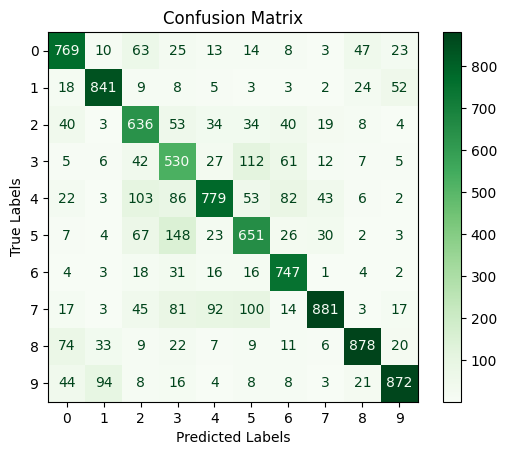

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(all_predictions, all_targets)
disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(10))
plt.figure(figsize=(10, 8))
disp.plot(cmap="Greens", values_format="d")

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

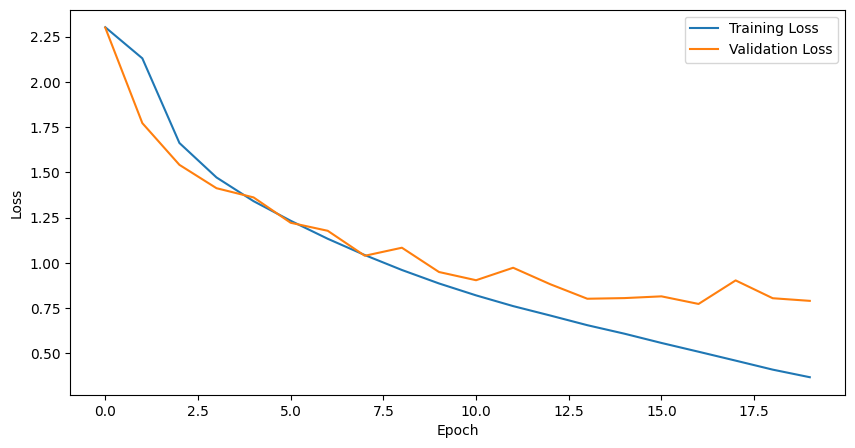

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(Train_loss_list , label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


**1_B**

In [18]:
model = ModelNet(dropout=True)
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [20]:
Train_loss_list, val_loss_list, val_accuracy_list = [], [], []

epochs = 20
for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(trainLoader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    Train_loss_list.append(running_loss / len(trainLoader))

    # Validation loop
    running_loss = 0.0
    correct = 0
    total = 0
    model.eval()
    all_predictions, all_targets = [], []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testLoader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.tolist())
            all_targets.extend(labels.tolist())

    val_loss_list.append(running_loss / len(testLoader))
    val_accuracy = 100 * correct / total
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch {epoch + 1}, Training loss: {Train_loss_list[-1]:.4f}, Validation loss: {val_loss_list[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


Epoch 1, Training loss: 2.3022, Validation loss: 2.3003, Validation Accuracy: 13.74%
Epoch 2, Training loss: 2.1963, Validation loss: 1.9419, Validation Accuracy: 26.36%
Epoch 3, Training loss: 1.8234, Validation loss: 1.6762, Validation Accuracy: 37.43%
Epoch 4, Training loss: 1.6467, Validation loss: 1.6792, Validation Accuracy: 37.73%
Epoch 5, Training loss: 1.5094, Validation loss: 1.3976, Validation Accuracy: 47.51%
Epoch 6, Training loss: 1.3964, Validation loss: 1.3508, Validation Accuracy: 50.21%
Epoch 7, Training loss: 1.3011, Validation loss: 1.2587, Validation Accuracy: 53.19%
Epoch 8, Training loss: 1.2167, Validation loss: 1.1631, Validation Accuracy: 57.36%
Epoch 9, Training loss: 1.1392, Validation loss: 1.1582, Validation Accuracy: 58.80%
Epoch 10, Training loss: 1.0730, Validation loss: 0.9975, Validation Accuracy: 63.79%
Epoch 11, Training loss: 1.0139, Validation loss: 0.9691, Validation Accuracy: 65.80%
Epoch 12, Training loss: 0.9563, Validation loss: 0.9203, Valid

In [21]:
# Final evaluation
model.eval()
all_predictions, all_targets = [], []
with torch.no_grad():
    for i, (inputs, targets) in enumerate(testLoader, 0):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.tolist())
        all_targets.extend(targets.tolist())


In [22]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(all_targets, all_predictions) * 100
precision, recall, f1 = precision_score(all_targets, all_predictions, average='weighted'), recall_score(all_targets, all_predictions, average='weighted'), f1_score(all_targets, all_predictions, average='weighted')

# Print the metrics
print(f'Accuracy: {accuracy}%')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 74.32%
Precision: 0.7505268161197706
Recall: 0.7432
F1 Score: 0.7432990699238232


In [23]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 2356938


<Figure size 1000x800 with 0 Axes>

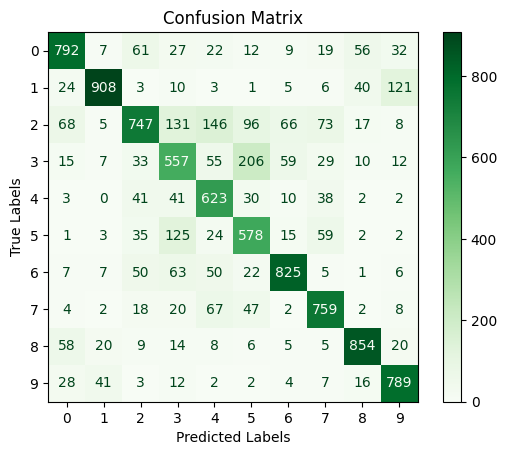

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(all_predictions, all_targets)
disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(10))
plt.figure(figsize=(10, 8))
disp.plot(cmap="Greens", values_format="d")

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

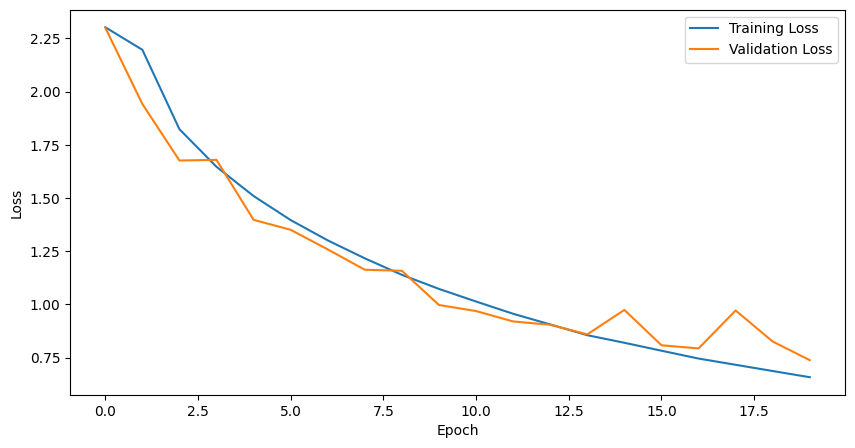

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(Train_loss_list , label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
